In [1]:
import numpy as np
import pandas as pd
import cPickle
from collections import defaultdict
import re

import gensim

from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.decomposition import TruncatedSVD

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import Adadelta
from keras.constraints import unitnorm
from keras.regularizers import l2
from keras.utils import np_utils
from keras import callbacks

import lda

import matplotlib.pyplot as plt

from __future__ import division
%matplotlib inline

Using Theano backend.


# LOAD DATA

In [2]:
def get_idx_from_sent(sent, word_idx_map, max_l, kernel_size=5):
    """
    Transforms sentence into a list of indices. Pad with zeroes.
    """
    x = []
    pad = kernel_size - 1
    for i in xrange(pad):
        x.append(0)
    words = sent.split()
    for word in words:
        if word in word_idx_map:
            x.append(word_idx_map[word])
    while len(x) < max_l+2*pad:
        x.append(0)
    return x

def make_idx_data(revs, word_idx_map, max_l, kernel_size=5):
    """
    Transforms sentences into a 2-d matrix.
    """
    train, val, test = [], [], []
    for rev in revs:
        sent = get_idx_from_sent(rev['text'], word_idx_map, max_l, kernel_size)
        sent = sent+list(rev['ue'])# added
        sent.append(rev['y'])
        if rev['split'] == 1:
            train.append(sent)
        elif rev['split'] == 0:
            val.append(sent)
        else:
            test.append(sent)
    train = np.array(train, dtype=np.int)
    val = np.array(val, dtype=np.int)
    test = np.array(test, dtype=np.int)
    return [train, val, test]

# load data
print "loading data..."
x = cPickle.load(open("../data/twitter-train-val-test_ue.pickle", "rb"))
revs, W, word_idx_map, vocab = x[0], x[1], x[2], x[3]
print "data loaded!"

print 'max_l should be set :', np.max(pd.DataFrame(revs)['num_words'])  

loading data...
data loaded!
max_l should be set : 34


In [3]:
datasets = make_idx_data(revs, word_idx_map, max_l=34, kernel_size=5)  #*** must set max_l

In [4]:
# Train data preparation
N = datasets[0].shape[0]
conv_input_width = W.shape[1]
conv_input_height = int(datasets[0].shape[1]-1)

# For each word write a word index (not vector) to X tensor
train_X = np.zeros((N, conv_input_height), dtype=np.int)
train_Y = np.zeros((N, 2), dtype=np.int)
for i in xrange(N):
    for j in xrange(conv_input_height):
        train_X[i, j] = datasets[0][i, j]
    train_Y[i, datasets[0][i, -1]] = 1
    
print 'train_X.shape = {}'.format(train_X.shape)
print 'train_Y.shape = {}'.format(train_Y.shape)
print '----------------------------------------------------------'


# Validation data preparation
Nv = datasets[1].shape[0]

# For each word write a word index (not vector) to X tensor
val_X = np.zeros((Nv, conv_input_height), dtype=np.int)
val_Y = np.zeros((Nv, 2), dtype=np.int)
for i in xrange(Nv):
    for j in xrange(conv_input_height):
        val_X[i, j] = datasets[1][i, j]
    val_Y[i, datasets[1][i, -1]] = 1
    
print 'val_X.shape = {}'.format(val_X.shape)
print 'val_Y.shape = {}'.format(val_Y.shape)
print '----------------------------------------------------------'



# Test data preparation
Nt = datasets[2].shape[0]

# For each word write a word index (not vector) to X tensor
test_X = np.zeros((Nt, conv_input_height), dtype=np.int)
test_Y = np.zeros((Nt, 2), dtype=np.int)
for i in xrange(Nt):
    for j in xrange(conv_input_height):
        test_X[i, j] = datasets[2][i, j]
    test_Y[i, datasets[2][i, -1]] = 1
    
print 'test_X.shape = {}'.format(test_X.shape)
print 'test_Y.shape = {}'.format(test_Y.shape)
print '----------------------------------------------------------'

# Other Information
max_l = np.max(pd.DataFrame(revs)['num_words'])     #记录最长句子的单词量
print 'number of sentences: ' + str(len(revs))
print 'vocab size: ' + str(len(vocab))
print 'max sentence length: ' + str(max_l)
print 'W shape',W.shape
print 'word_idx_map length',len(word_idx_map)
print 'conv_input_height',conv_input_height
print 'conv_input_width',conv_input_width

train_X.shape = (4028L, 55L)
train_Y.shape = (4028L, 2L)
----------------------------------------------------------
val_X.shape = (972L, 55L)
val_Y.shape = (972L, 2L)
----------------------------------------------------------
test_X.shape = (5000L, 55L)
test_Y.shape = (5000L, 2L)
----------------------------------------------------------
number of sentences: 10000
vocab size: 18154
max sentence length: 34
W shape (18155L, 500L)
word_idx_map length 18154
conv_input_height 55
conv_input_width 500


# BUILD MODEL

In [5]:
# Number of feature maps (outputs of convolutional layer)
N_fm = 300
# kernel size of convolutional layer
kernel_size = 8

model = Sequential()
# Embedding layer (lookup table of trainable word vectors)
model.add(Embedding(input_dim=W.shape[0], 
                    output_dim=W.shape[1], 
                    input_length=conv_input_height,
                    weights=[W], 
                    W_constraint=unitnorm()))
# Reshape word vectors from Embedding to tensor format suitable for Convolutional layer
model.add(Reshape((1, conv_input_height, conv_input_width)))

# first convolutional layer
model.add(Convolution2D(N_fm, 
                        kernel_size, 
                        conv_input_width, 
                        border_mode='valid', 
                        W_regularizer=l2(0.0001)))
# ReLU activation
model.add(Activation('relu'))

# aggregate data in every feature map to scalar using MAX operation
model.add(MaxPooling2D(pool_size=(conv_input_height-kernel_size+1, 1)))

model.add(Flatten())
model.add(Dropout(0.5))
# Inner Product layer (as in regular neural network, but without non-linear activation function)
model.add(Dense(2))
# SoftMax activation; actually, Dense+SoftMax works as Multinomial Logistic Regression
model.add(Activation('softmax'))

# Custom optimizers could be used, though right now standard adadelta is employed
opt = Adadelta(lr=1.0, rho=0.95, epsilon=1e-6)
model.compile(loss='categorical_crossentropy', 
              optimizer=opt,
              metrics=['accuracy'])

WARNING (theano.gof.cmodule): ModuleCache.refresh() Found key without dll in cache, deleting it. C:\Users\younggy\AppData\Local\Theano\compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.12-64\tmps3tl0i\key.pkl
INFO (theano.gof.compilelock): Waiting for existing lock by process '15368' (I am process '28596')
INFO:theano.gof.compilelock:Waiting for existing lock by process '15368' (I am process '28596')
INFO (theano.gof.compilelock): To manually release the lock, delete C:\Users\younggy\AppData\Local\Theano\compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.12-64\lock_dir
INFO:theano.gof.compilelock:To manually release the lock, delete C:\Users\younggy\AppData\Local\Theano\compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.12-64\lock_dir


In [6]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_1 (Embedding)          (None, 55, 500L)      9077500     embedding_input_1[0][0]          
____________________________________________________________________________________________________
reshape_1 (Reshape)              (None, 1, 55, 500L)   0           embedding_1[0][0]                
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 300, 48, 1L)   1200300     reshape_1[0][0]                  
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 300, 48, 1L)   0           convolution2d_1[0][0]            
___________________________________________________________________________________________

# MODEL TRAINING

In [7]:
history = model.fit(train_X, train_Y, batch_size=50, nb_epoch=100, verbose=1,validation_split=0.2)

Train on 3222 samples, validate on 806 samples
Epoch 1/100
3222/3222 [==============================] - 58s - loss: 0.6891 - acc: 0.5341 - val_loss: 0.6712 - val_acc: 0.6414
Epoch 2/100
3222/3222 [==============================] - 57s - loss: 0.6296 - acc: 0.6629 - val_loss: 0.6132 - val_acc: 0.6824
Epoch 3/100
3222/3222 [==============================] - 61s - loss: 0.5522 - acc: 0.7353 - val_loss: 0.5400 - val_acc: 0.7308
Epoch 4/100
3222/3222 [==============================] - 59s - loss: 0.4863 - acc: 0.7765 - val_loss: 0.5683 - val_acc: 0.7196
Epoch 5/100
3222/3222 [==============================] - 59s - loss: 0.4128 - acc: 0.8228 - val_loss: 0.6982 - val_acc: 0.6898
Epoch 6/100
3222/3222 [==============================] - 63s - loss: 0.3458 - acc: 0.8625 - val_loss: 0.5988 - val_acc: 0.7258
Epoch 7/100
3222/3222 [==============================] - 62s - loss: 0.2511 - acc: 0.9032 - val_loss: 0.6532 - val_acc: 0.7295
Epoch 8/100
3222/3222 [==============================] - 62s - l

# MODEL EVALUATION

In [8]:
%matplotlib inline
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

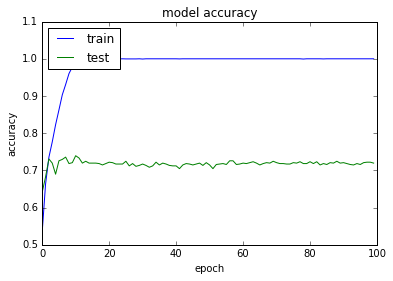

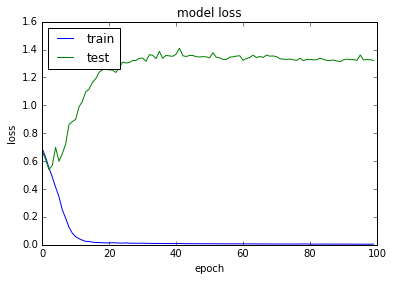

In [9]:
plot_history(history)

# MODEL TESTING

In [10]:
p = model.predict_proba(test_X, batch_size=10)
np.mean(np.argmax(test_Y,axis=1)==np.argmax(p,axis=1))

5000/5000 [==============================] - 33s    


0.70579999999999998